## Overview

In [173]:

#This code seeks to build a PINN that returns the concentration of gases and temperature across discretized points in an ammonia cracking reactor.

"""
This is achieved in the following steps:

  1. Import a PDE solver for the CDRS Equation for Ammonia Cracking and use it to solve for the concentration of gases and temperature across discretized points in times t.
  2. Outline the structure of an NN and initialise random parameters.
  3. Construct Pseudoinverse Matrix Ax = b and obtain x.
  4. Obtain fitness of NN by computing Data Loss and Physics Loss
  5. Recalibrate Parameters
"""

'\nThis is achieved in the following steps:\n\n  1. Import a PDE solver for the CDRS Equation for Ammonia Cracking and use it to solve for the concentration of gases and temperature across discretized points in times t.\n  2. Outline the structure of an NN and initialise random parameters.\n  3. Construct Pseudoinverse Matrix Ax = b and obtain x.\n  4. Obtain fitness of NN by computing Data Loss and Physics Loss\n  5. Recalibrate Parameters\n'

## Imports

In [ ]:
from Compiled_helper_functions import *

Mounted at /content/drive


In [ ]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from jax.scipy.linalg import solve

import time
import numpy as np
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

get_ipython().system('pip install evojax')
from evojax.util import get_params_format_fn

In [176]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

## Import Steady State Solution

In [ ]:
# Import Solution
y_steady = np.load('steady_state_sol.npy')

# Create Class Objects
reac = Reac()
oper = Oper(reac)

In [178]:
# NH3 and T_x sol
y_steady_reshaped = y_steady.reshape(reac.Ns + 1, reac.Nx, order ='C')
y_shortened = y_steady_reshaped
Y_NH3 = y_shortened[0]
T_x = y_shortened[-1]

sol = y_shortened.reshape(1,-1, order = 'C')
print(y_shortened)
print(Y_NH3)


[[9.95000000e-01 9.94694363e-01 9.94404470e-01 ... 9.07179510e-01
  9.07126571e-01 9.07094143e-01]
 [2.50000000e-03 2.95845494e-03 3.39329442e-03 ... 1.34230734e-01
  1.34310143e-01 1.34358786e-01]
 [2.50000000e-03 2.65281831e-03 2.79776481e-03 ... 4.64102448e-02
  4.64367143e-02 4.64529287e-02]
 [8.04568806e-21 8.04568806e-21 8.04568806e-21 ... 8.04568846e-21
  8.04568846e-21 8.04568847e-21]
 [7.71500000e+02 7.71698166e+02 7.71785597e+02 ... 7.72750784e+02
  7.72750853e+02 7.72750899e+02]]
[0.995      0.99469436 0.99440447 ... 0.90717951 0.90712657 0.90709414]


## Outline Structure of NN and Initialise Random Parameters


In [189]:
# PINN

n_l = 4
class PINN(nn.Module):
    """PINNs"""
    def setup(self):
      #single hidden layer
        self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                        jnp.sin,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                       nn.swish,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                       nn.tanh,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                       jnp.exp
                       ]
        #self.last_layer = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)


    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        # t = inputs
        x = inputs
        def get_u(x):
            # f = t / 10 - 0.4
            f = x
            fs = []
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                """For sin activation"""
                if (i == 0):
                    pre_act = f
                    f = 2*jnp.pi*f #first hidden layer mult by 2pi
                if (i%2 != 0):
                    fs.append(f)
            fs = jnp.hstack(fs) #stop at the hidden layer before output
            #u = self.last_layer(f)
            return f, pre_act, fs

        f, pre_act, fs = get_u(x)

        # obtain f_t
        def get_f_dir(get_u, x):
            # f_t = jacfwd(get_u)(t)  # much faster (10x) than u_xx, f_xx = hessian(get_u)(x, y)
            f_x = jacfwd(lambda x: get_u(x)[0])(x)  # much faster (10x) than u_xx, f_xx = hessian(get_u)(x, y)
            f_xx = jacfwd(jacfwd(lambda x: get_u(x)[0]))(x)

            f_x = jnp.squeeze(f_x, axis= -1)
            f_xx = jnp.squeeze(f_xx, axis= (-1,-2))
            print(f_xx.shape)
            return f_xx, f_x

        f_dir_vmap = vmap(get_f_dir, in_axes=(None, 0))
        f_xx, f_x = f_dir_vmap(get_u, x)


        outputs = jnp.hstack([f, f_x, f_xx])

        return outputs, pre_act

In [190]:
# choose seed
seed = 10
key, rng = random.split(random.PRNGKey(seed))

# dummy input
a = random.normal(key, [1, 1]) #only for x

# initialization call
n_nodes = 256
# n_nodes = 350
# n_nodes = 128
# n_nodes = 64
model = PINN()
params = model.init(key, a)
num_params, format_params_fn = get_params_format_fn(params)

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

# for inverst problem - append params to include 2 more parameters
key, rng = random.split(rng) # update random generator
# ini_a = random.normal(key, [1, n_e + 1]) #one for lmbda, other for lambda
ini_a = random.normal(key, [1, 1]) #one for lmbda, other for lambda
params = jnp.append(params, ini_a)
print(ini_a)

(256,)
[[0.27489732]]


## Evaluating PDE Constants

In [191]:
def regularization_factor(params):
  reg = 10**(nn.tanh(params)*5)

  return reg

In [192]:
def eval_loss(params):

  # Apply Model
  shaped_xvals = reac.xvals.reshape(reac.Nx, 1)
  #jax.debug.print("shaped_xvals {x}", x=shaped_xvals)
  pred, pre_act = model.apply(format_params_fn(params[:-1]), shaped_xvals)
  f, f_x, f_xx = jnp.split(pred, 3, axis=1)
  #print("f", f.shape)
  #print("f_x", f_x.shape)
  #print("f_xx", f_xx.shape)

  # Initial Guess of NH3 and T
  """
  Random Generation
  key1, key2, rng = jax.random.split(key, 3)
  Y_NH3 = jax.random.normal(key1, [1, reac.Nx])
  T_x = jax.random.normal(key2, [1, reac.Nx])
  """


  coeffs = gen_coeffs(y_steady, reac, oper)
  coeffs = coeffs
  #jax.debug.print("coeffs: {c}", c= coeffs.T)

  # Generate Matrix A

  pde_A1 = coeffs[:,0].reshape(-1,1) * f_xx + coeffs[:,1].reshape(-1,1) * f_x
  bc_NH3_A = f[0]
  bc2_NH3_A = f_x[-1]
  A = jnp.vstack([pde_A1, bc_NH3_A, bc2_NH3_A])

  # Generate RHS

  reg = regularization_factor(params[-1]) #10**(nn.sigmoid(params[-1])*4 - 6)
  #jax.debug.print("reg: {r}", r = reg)

  # Generate RHS
  pde_b1 = -coeffs[:,2].reshape(-1,1)
  b = jnp.vstack([pde_b1, jnp.array(0.995), jnp.array(0.0)])
  #jax.debug.print("b: {b}", b = b)

  As, bs = reg*jnp.eye(A.shape[1]) + (A.T@A), A.T@b #this is least squares  (A.T@A)
  w_PI = solve(As, bs)
  #jax.debug.print("W: {w}", w= w_PI)

  """
  jax.debug.print("f, {f}", f = f)
  jax.debug.print("f_x, {f}", f = f_x)
  jax.debug.print("f_xx, {f}", f = f_xx)
  """

  pred1 = f @ w_PI
  #jax.debug.print("Pred1 = {w}", w= pred1)
  #pred2 = f @ w_PI[1*n_nodes:2*n_nodes, :]
  #pred_all = jnp.hstack([pred1, pred2])


  pde_residual = A @ w_PI
  pde_residual = pde_residual.reshape(reac.Nx + 2, 1) # CHANGED FOR 1 VARIABLE
  pde_right = b.reshape(reac.Nx + 2,1) # CHANGED FOR 1 VARIABLE
  pde_loss = jnp.mean(jnp.square(pde_residual - pde_right))


  # ssr, mse, rl2
  ssr = jnp.sum((b - A @ w_PI)**2)
  # mse = jnp.mean(jnp.square(gt_solver - pred_all))
  #mse = jnp.sum(jnp.mean(jnp.square(sol - pred_all), axis=0))
  #mse = jnp.sum(jnp.mean(jnp.square(Y_NH3 - pred1), axis=0))

  #max_gt = jnp.max(gt_solver, axis=0)
  #rl2 = jnp.sum(jnp.linalg.norm(gt_solver - pred_all, axis=0)/max_gt)

  rl2_A = jnp.linalg.norm(Y_NH3.reshape(-1, 1) - pred1) / jnp.linalg.norm(Y_NH3.reshape(-1, 1))

  loss = rl2_A + pde_loss

  return loss, (ssr, rl2_A, pde_loss)

loss_grad = jax.jit(jax.value_and_grad(eval_loss, has_aux=True))
# loss_grad = jax.value_and_grad(eval_loss, has_aux=True)



# weights update
@jit
def update(params, opt_state):
    (loss, (ssr, rl2, pde_loss)), grad0 = loss_grad(params)
    return loss, ssr, rl2, pde_loss, grad0

@jit
def update1(params, opt_state, grads):
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state



In [193]:
# optimizer
max_iters = 500
# max_iters = 200
max_lr = 1e-4


lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=max_lr, peak_value=max_lr, warmup_steps=int(max_iters*.2),
                                                  decay_steps=max_iters, end_value=1e-6)
#lr_scheduler = optax.cosine_decay_schedule(init_value=max_lr, decay_steps=max_iters * 2)


optimizer = optax.adam(learning_rate=lr_scheduler) # Choose the method
# optimizer = optax.adam(learning_rate=0.001) # Choose the method
opt_state = optimizer.init(params)


# training iteration
runtime = 0
train_iters = 0

store = []
para_all = {}

rl2_best = 1e10
while (train_iters <= max_iters):
    # mini-batch updater
    # key, rng = random.split(rng) # update random generator
    # if (train_iters % 20 == 0):
    #     para_all[train_iters] = params
    para_all[train_iters] = params

    losses, ssrs, rl2s, pde_losses, grads = 0, 0, 0, 0, 0
    loss, ssr, rl2, pde_loss, grad0 = update(params, opt_state)
    grads = grads + grad0
    losses = losses + loss
    ssrs = ssrs + ssr
    rl2s = rl2s + rl2
    pde_losses = pde_losses + pde_loss
    params, opt_state = update1(params, opt_state, grads)

    if jnp.isnan(losses).any() or jnp.isnan(grads).any():
      print(f"NaN detected at iteration {train_iters}. Stopping training.")
      break




    # append weights
    if (train_iters % 1 == 0):
        reg = regularization_factor(params[-1]) #10**(nn.sigmoid(params[-1])*4 - 6)
        print ('iter. = %05d,  time = %03ds,  loss = %.4e,  ssr = %.4e,  rl2s = %.4e, pde = %.4e,reg = %.4e'%(train_iters, runtime, losses, ssrs, rl2s, pde_losses, reg))
        store.append([train_iters, runtime, losses, ssrs, pde_losses, rl2s])

    if rl2s < rl2_best:
        rl2s_best = rl2s
        jnp.save('best_0', para_all[train_iters])

    train_iters += 1

store = jnp.array(store)


(256,)
iter. = 00000,  time = 000s,  loss = 1.4080e-01,  ssr = 2.4128e-02,  rl2s = 1.4078e-01, pde = 2.4056e-05,reg = 2.1899e+01
iter. = 00001,  time = 000s,  loss = 1.3052e-01,  ssr = 2.0811e-02,  rl2s = 1.3050e-01, pde = 2.0749e-05,reg = 2.1875e+01
iter. = 00002,  time = 000s,  loss = 1.2357e-01,  ssr = 1.8825e-02,  rl2s = 1.2355e-01, pde = 1.8769e-05,reg = 2.1852e+01
iter. = 00003,  time = 000s,  loss = 1.1816e-01,  ssr = 1.7436e-02,  rl2s = 1.1814e-01, pde = 1.7384e-05,reg = 2.1829e+01
iter. = 00004,  time = 000s,  loss = 1.1362e-01,  ssr = 1.6357e-02,  rl2s = 1.1361e-01, pde = 1.6308e-05,reg = 2.1806e+01
iter. = 00005,  time = 000s,  loss = 1.0977e-01,  ssr = 1.5488e-02,  rl2s = 1.0976e-01, pde = 1.5442e-05,reg = 2.1783e+01
iter. = 00006,  time = 000s,  loss = 1.0652e-01,  ssr = 1.4793e-02,  rl2s = 1.0650e-01, pde = 1.4749e-05,reg = 2.1760e+01
iter. = 00007,  time = 000s,  loss = 1.0375e-01,  ssr = 1.4244e-02,  rl2s = 1.0374e-01, pde = 1.4201e-05,reg = 2.1737e+01
iter. = 00008,  t

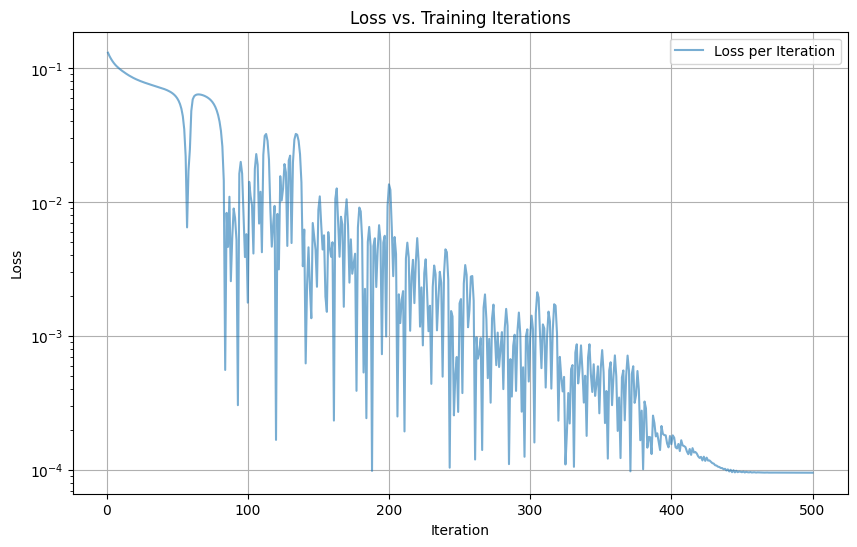

In [194]:
# Extract iteration and Loss data from the 'store' array
iterations = store[:, 0]
loss_values = store[:, 2]  # Loss is the 3rd column (index 2)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(iterations[1:], loss_values[1:], label='Loss per Iteration', alpha=0.6)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Training Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

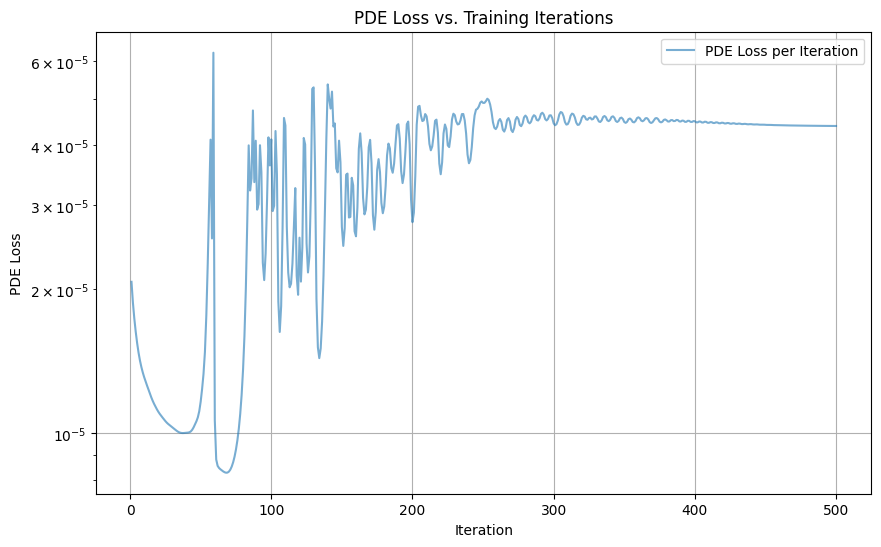

In [195]:

# Extract iteration and pde_loss data from the 'store' array
iterations = store[:, 0]
pde_loss_values = store[:, 4]  # pde_loss is the 5th column (index 4)

# Create the scatter plot for PDE loss
plt.figure(figsize=(10, 6))
plt.plot(iterations[1:], pde_loss_values[1:], label='PDE Loss per Iteration', alpha=0.6)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('PDE Loss')
plt.yscale('log')
plt.title('PDE Loss vs. Training Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


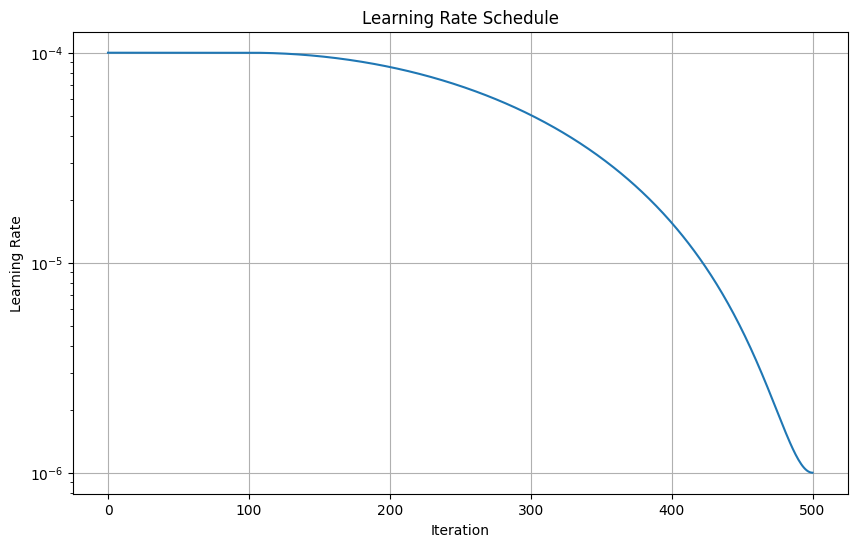

In [196]:
# Generate learning rate values over iterations
lrs = lr_scheduler(jnp.arange(max_iters + 1))

# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(jnp.arange(max_iters + 1), lrs)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

In [197]:
def eval_prediction(params):
  shaped_xvals = reac.xvals.reshape(reac.Nx, 1)
  pred, pre_act = model.apply(format_params_fn(params[:-1]), shaped_xvals)
  f, f_x, f_xx = jnp.split(pred, 3, axis=1)


  coeffs = gen_coeffs(y_steady, reac, oper)

  pde_A1 = coeffs[:,0].reshape(-1,1) * f_xx + coeffs[:,1].reshape(-1,1) * f_x
  bc_NH3_A = f[0]
  bc2_NH3_A = f_x[-1]
  A = jnp.vstack([pde_A1, bc_NH3_A, bc2_NH3_A])

  # Generate RHS

  reg = regularization_factor(params[-1]) #10**(nn.sigmoid(params[-1])*4 - 6)
  #jax.debug.print("reg: {r}", r = reg)

  # Generate RHS
  pde_b1 = -coeffs[:,2].reshape(-1,1)
  b = jnp.vstack([pde_b1, jnp.array(0.995), jnp.array(0.0)])
  #jax.debug.print("b: {b}", b = b)

  As, bs = reg*jnp.eye(A.shape[1]) + (A.T@A), A.T@b #this is least squares  (A.T@A)
  w_PI = solve(As, bs)
  pred1 = f @ w_PI

  return pred1, pre_act

(256,)


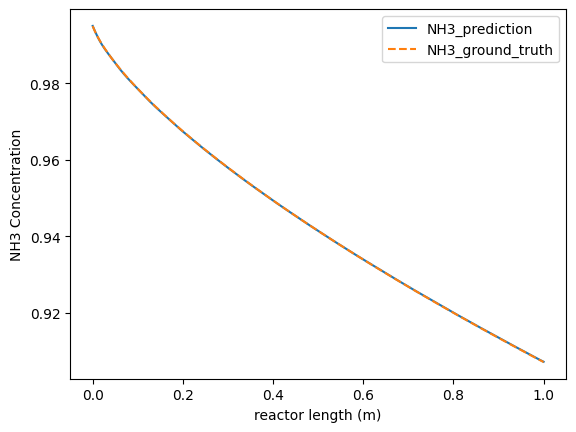

In [199]:
pred1, pre_act = eval_prediction(params)


fig = plt.figure
shaped_xvals = reac.xvals.reshape(reac.Nx, 1)
plt.plot(shaped_xvals, pred1, label='NH3_prediction')
plt.plot(shaped_xvals, Y_NH3, linestyle = 'dashed', label='NH3_ground_truth')
plt.xlabel('reactor length (m)')
plt.ylabel('NH3 Concentration')
plt.legend()
plt.show()